In [77]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

In [78]:
model_config_path = "config/DINO/DINO_4scale_swin.py" # change the path of the model config file
model_checkpoint_path = "logs/DINO/Swin/checkpoint_best_regular.pth" # change the path of the model checkpoint

In [79]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
args.backbone_dir = "./"
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
_IncompatibleKeys(missing_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.7.attn_mask', 'layers.2.blocks.9.attn_mask', 'layers.2.blocks.11.attn_mask', 'layers.2.blocks.13.attn_mask', 'layers.2.blocks.15.attn_mask', 'layers.2.blocks.17.attn_mask'])


In [80]:
# load coco names
with open('nuimages_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
    
#load image_meta_data
with open('../nuimages/annotations/instances_val2017.json') as f:
    instances = json.load(f)
    images_meta = instances['images']

In [81]:
args.dataset_file = 'coco'
args.coco_path = "../nuimages/"
args.fix_size = True

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


In [104]:
image, targets = dataset_val[9000]

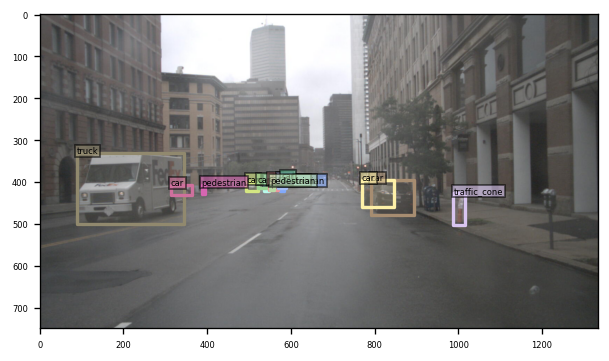

In [105]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

In [106]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [107]:
thershold = 0.1 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

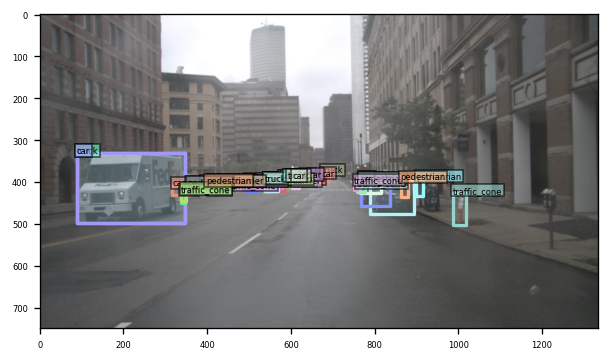

In [108]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)